In [6]:
import io
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
import missingno as msno
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from scipy.stats import pearsonr


In [1]:
from google.colab import files
upload = files.upload()

Saving listing7.4.xlsx to listing7.4.xlsx


In [7]:
df = pd.read_excel(io.BytesIO(upload['listing7.4.xlsx']))

In [8]:


# Define your numerical and categorical columns
numerical_cols = ['beds', 'latitude', 'longitude']
categorical_cols = ['neighbourhood', 'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'property_type', 'room_type']

# Handle missing data for numerical columns (Example: fill with mean or median)
for col in numerical_cols:
    df[col].fillna(df[col].mean(), inplace=True)

# One-hot encode the categorical columns
onehot_encoder = OneHotEncoder(sparse_output=False, drop='first')  # Updated parameter
encoded_categorical = onehot_encoder.fit_transform(df[categorical_cols])
encoded_categorical_df = pd.DataFrame(encoded_categorical, columns=onehot_encoder.get_feature_names_out())

# Standardize the numerical columns
scaler = StandardScaler()
scaled_numerical = scaler.fit_transform(df[numerical_cols])
scaled_numerical_df = pd.DataFrame(scaled_numerical, columns=numerical_cols)

# Combine the encoded categorical and scaled numerical data into one DataFrame
combined_df = pd.concat([scaled_numerical_df, encoded_categorical_df], axis=1)

# Initialize a correlation matrix
correlation_matrix = pd.DataFrame(index=combined_df.columns, columns=combined_df.columns)

# Calculate the correlation matrix
for col1 in combined_df.columns:
    for col2 in combined_df.columns:
        # Skip redundant calculations
        if not pd.isna(correlation_matrix.loc[col1, col2]) or col1 == col2:
            correlation_matrix.loc[col1, col2] = 1.0
            continue

        # Calculate correlation only between numerical features
        if col1 in numerical_cols and col2 in numerical_cols:
            correlation_matrix.loc[col1, col2] = pearsonr(combined_df[col1].dropna(), combined_df[col2].dropna())[0]
            # Symmetric value
            correlation_matrix.loc[col2, col1] = correlation_matrix.loc[col1, col2]

# The correlation_matrix now contains the Pearson correlations between numerical features
# Categorical features are one-hot encoded and can be used as binary variables in modelling,
# but they do not have a meaningful Pearson correlation with other variables

# Return or save the correlation matrix
print(correlation_matrix)


                                                   beds  latitude longitude  \
beds                                                1.0  0.077354 -0.134081   
latitude                                            1.0       1.0 -0.147027   
longitude                                           1.0       1.0       1.0   
neighbourhood_Ambar?s-et-Lagrave, Nouvelle-Aqui...  NaN       NaN       NaN   
neighbourhood_Artigues-pr?s-Bordeaux, Nouvelle-...  NaN       NaN       NaN   
...                                                 ...       ...       ...   
property_type_Tiny home                             NaN       NaN       NaN   
property_type_Treehouse                             NaN       NaN       NaN   
room_type_Hotel room                                NaN       NaN       NaN   
room_type_Private room                              NaN       NaN       NaN   
room_type_Shared room                               NaN       NaN       NaN   

                                                   

In [9]:
# First, ensure 'revenue' is treated appropriately, either by scaling it as a numerical variable or directly including it if it doesn't need scaling
if 'revenue' in numerical_cols:
    # If 'revenue' needs to be scaled
    numerical_cols_with_revenue = numerical_cols + ['revenue']
    scaled_numerical_with_revenue = scaler.fit_transform(df[numerical_cols_with_revenue])
    scaled_numerical_df_with_revenue = pd.DataFrame(scaled_numerical_with_revenue, columns=numerical_cols_with_revenue)
    # Combine with encoded categorical DataFrame
    combined_df_with_revenue = pd.concat([scaled_numerical_df_with_revenue, encoded_categorical_df], axis=1)
else:
    # If 'revenue' does not need to be scaled or is already processed
    combined_df_with_revenue = pd.concat([combined_df, df[['revenue']]], axis=1)

# Now calculate the correlation of 'revenue' with all other features
correlation_with_revenue = combined_df_with_revenue.corr()['revenue']

# To get correlations of 'revenue' with all features, excluding itself
correlation_with_revenue_excl_self = correlation_with_revenue.drop('revenue')

# Print or return the correlation series
print(correlation_with_revenue_excl_self)


beds                                                               -0.035571
latitude                                                           -0.008521
longitude                                                          -0.006601
neighbourhood_Ambar?s-et-Lagrave, Nouvelle-Aquitaine, France        0.005318
neighbourhood_Artigues-pr?s-Bordeaux, Nouvelle-Aquitaine, France   -0.020325
                                                                      ...   
property_type_Tiny home                                             0.005772
property_type_Treehouse                                             0.009336
room_type_Hotel room                                               -0.027517
room_type_Private room                                              0.026064
room_type_Shared room                                              -0.013329
Name: revenue, Length: 199, dtype: float64


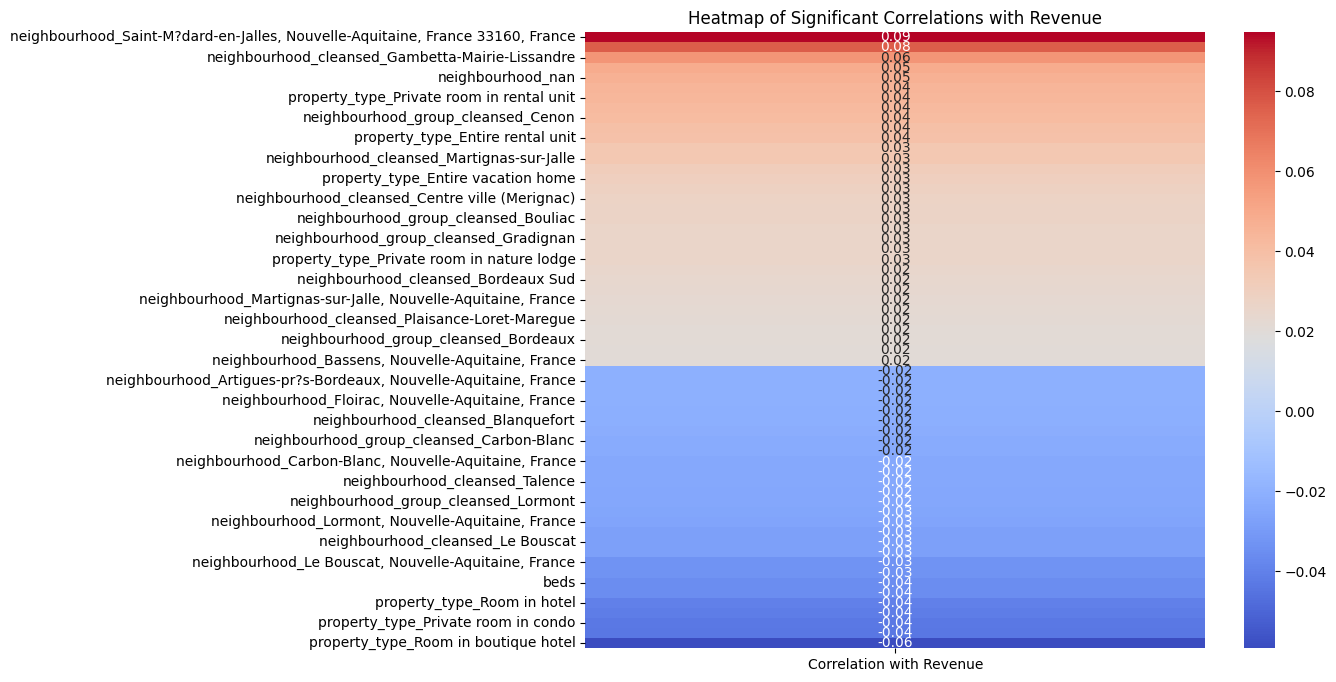

In [10]:
# Set a threshold for filtering significant correlations
threshold = 0.02

# Filter out correlations below the threshold
significant_corrs = correlation_with_revenue_excl_self[abs(correlation_with_revenue_excl_self) >= threshold]

# Convert to DataFrame for seaborn heatmap compatibility
significant_corrs_df = significant_corrs.to_frame()  # Converts the Series to a DataFrame
significant_corrs_df.columns = ['Correlation with Revenue']  # Rename column for clarity

# Plotting the heatmap
plt.figure(figsize=(10, 8))  # Adjust size as necessary
sns.heatmap(significant_corrs_df.sort_values(by='Correlation with Revenue', ascending=False),
            annot=True, cmap='coolwarm', cbar=True, fmt=".2f")
plt.title('Heatmap of Significant Correlations with Revenue')
plt.show()



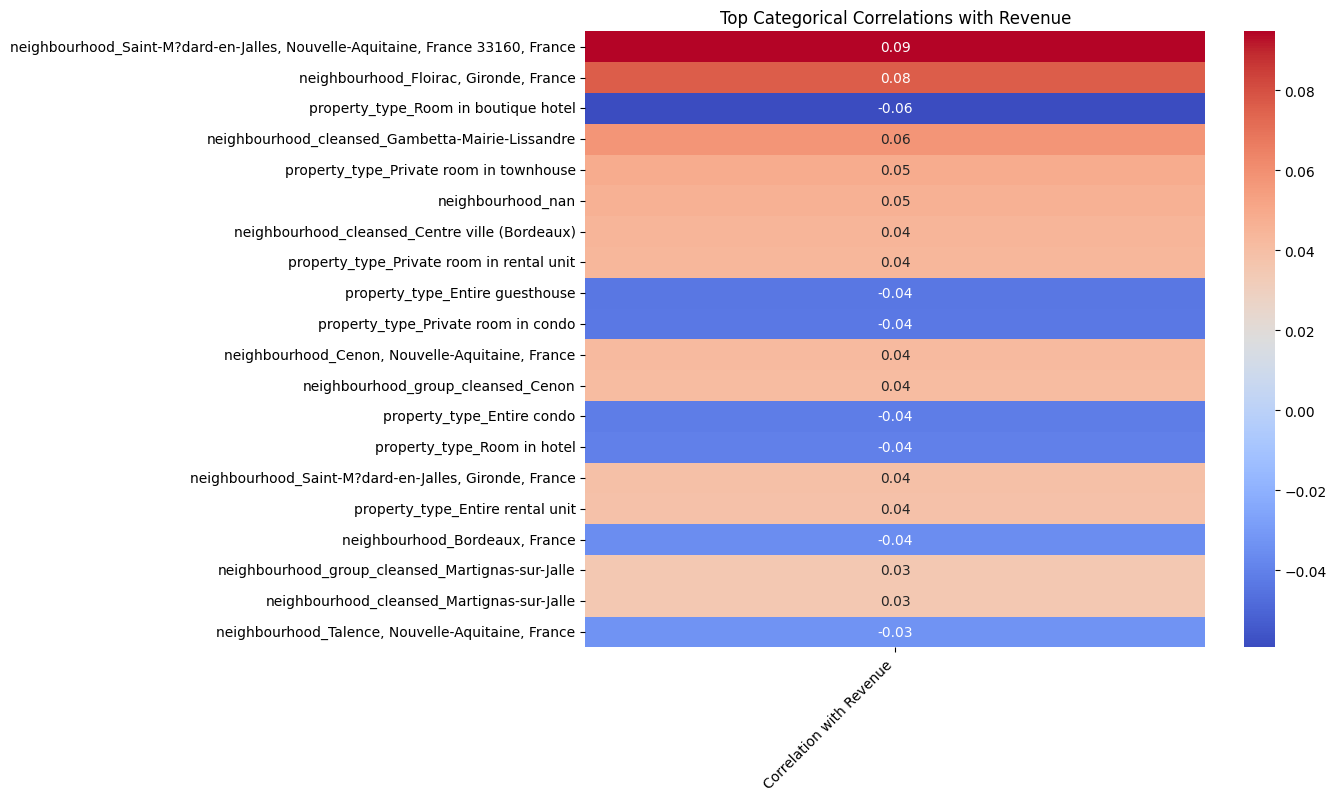

In [12]:
# Sort the correlations by their absolute values but keep the original sign
top_categorical_corrs = categorical_corrs.abs().sort_values(ascending=False).head(N)

# Use the original Series to keep the sign of the correlations
final_corrs = categorical_corrs[top_categorical_corrs.index]

# Convert to DataFrame for seaborn heatmap compatibility, this time directly
final_corrs_df = final_corrs.to_frame()  # Converts the filtered Series to a DataFrame
final_corrs_df.columns = ['Correlation with Revenue']  # Rename column for clarity

# Plotting the heatmap
plt.figure(figsize=(10, 8))  # Adjust size as necessary
sns.heatmap(final_corrs_df, annot=True, cmap='coolwarm', cbar=True, fmt=".2f", yticklabels=True)
plt.title('Top Categorical Correlations with Revenue')
plt.xticks(rotation=45, ha='right')  # Improve readability of x labels
plt.show()


In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Assuming 'combined_df' is your DataFrame that includes both one-hot encoded categorical variables and 'revenue'
# Filter to keep only columns from one-hot encoded variables and 'revenue'. This might require adjusting based on your column naming.
categorical_columns = [col for col in combined_df.columns if '_' in col]  # Example criterion
categorical_columns_with_revenue = categorical_columns + ['revenue']

# Step 2: Create a new DataFrame that only includes these columns
filtered_df_for_corr = combined_df[categorical_columns_with_revenue]

# Step 3: Calculate the correlation matrix
correlation_matrix = filtered_df_for_corr.corr()

# Since the matrix could be very large, focus on 'revenue' correlation
correlation_with_revenue = correlation_matrix['revenue'].sort_values(ascending=False)

# Convert to DataFrame for visualization
correlation_with_revenue_df = correlation_with_revenue.to_frame()

# Step 4: Plotting the heatmap for 'revenue' correlations
plt.figure(figsize=(8, 12))  # Adjust size based on the number of categorical variables
sns.heatmap(correlation_with_revenue_df, annot=True, cmap='coolwarm', cbar=True, fmt=".2f")
plt.title('Correlation of Categorical Variables with Revenue')
plt.show()


KeyError: "['revenue'] not in index"

In [14]:
print('revenue' in df.columns)

True


In [15]:
# Add 'revenue' to your numerical_cols list if it's a numerical column and should be scaled
if 'revenue' in numerical_cols:
    scaled_numerical_with_revenue = scaler.fit_transform(df[numerical_cols + ['revenue']])
    scaled_numerical_df_with_revenue = pd.DataFrame(scaled_numerical_with_revenue, columns=numerical_cols + ['revenue'])
    combined_df_with_revenue = pd.concat([scaled_numerical_df_with_revenue, encoded_categorical_df], axis=1)
else:
    # If 'revenue' does not need scaling or is processed separately
    combined_df_with_revenue = pd.concat([combined_df, df[['revenue']]], axis=1)

# Proceed with your analysis using 'combined_df_with_revenue' instead of 'combined_df'


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


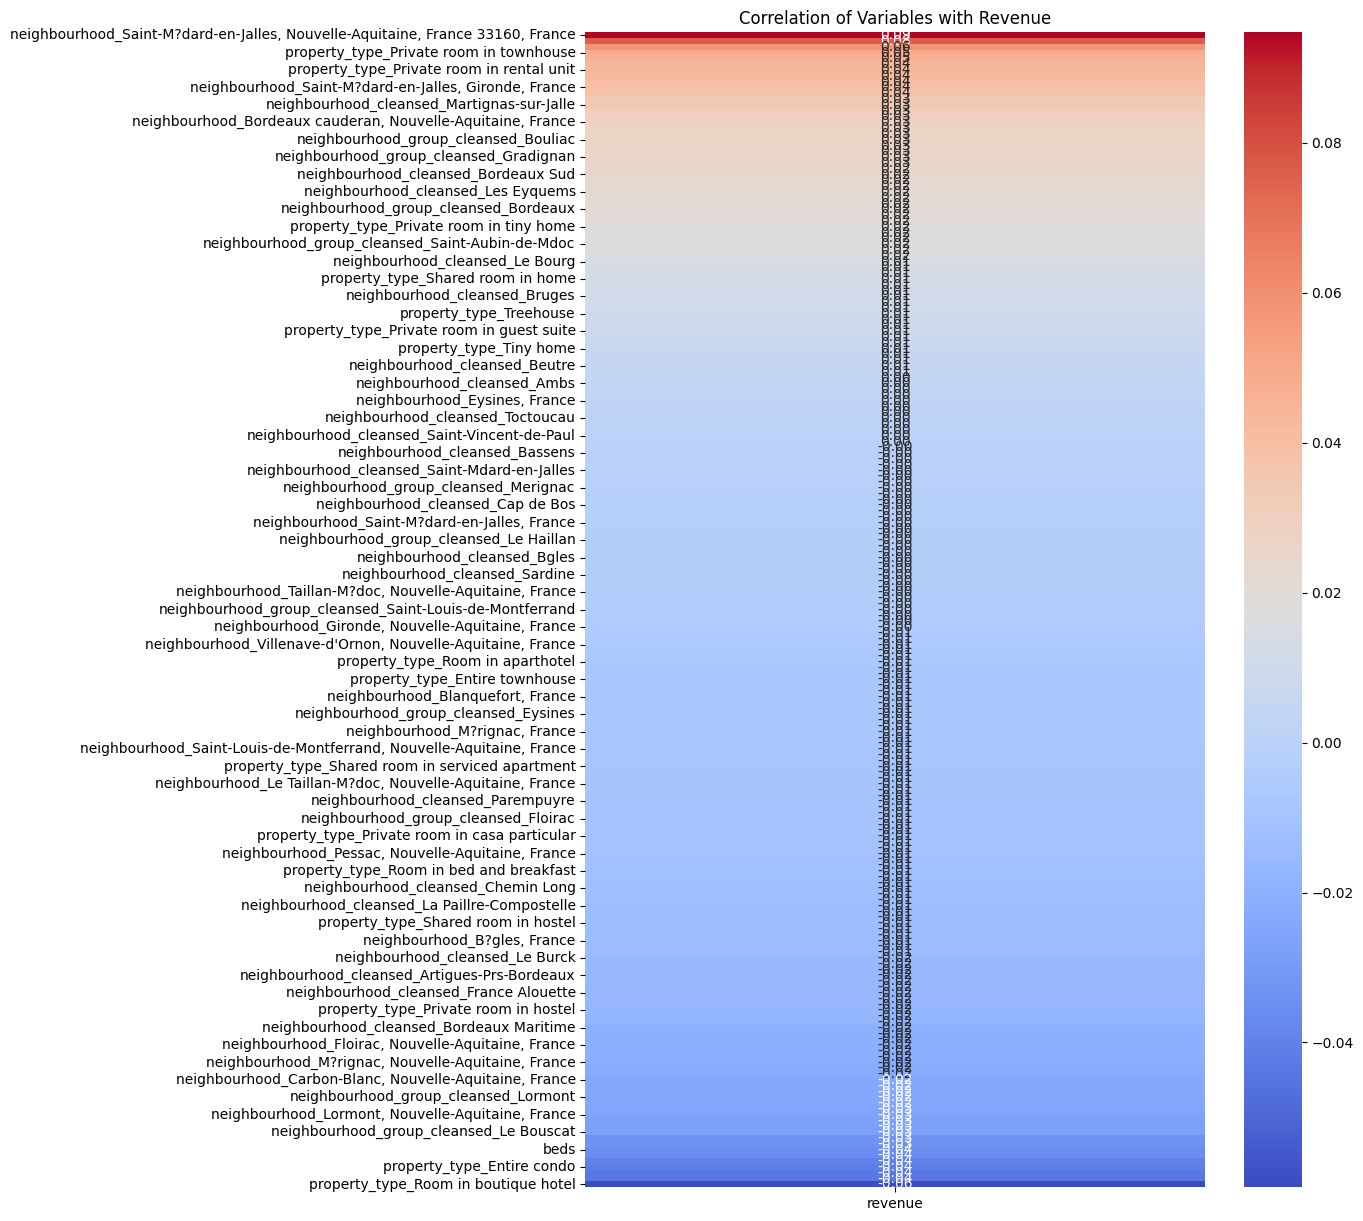

In [16]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt

# Loading the dataset (Replace this with your actual file path)
# df = pd.read_excel('C:/Users/user/Downloads/listing11.4.xlsx')


# Define your numerical and categorical columns
numerical_cols = ['beds', 'latitude', 'longitude']  # Example numerical columns
categorical_cols = ['neighbourhood', 'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'property_type', 'room_type']  # Example categorical columns

# One-hot encode the categorical columns
onehot_encoder = OneHotEncoder(sparse=False, drop='first')  # drop='first' to avoid dummy trap
encoded_categorical = onehot_encoder.fit_transform(df[categorical_cols])
encoded_categorical_df = pd.DataFrame(encoded_categorical, columns=onehot_encoder.get_feature_names_out())

# Standardize the numerical columns
scaler = StandardScaler()
scaled_numerical = scaler.fit_transform(df[numerical_cols])
scaled_numerical_df = pd.DataFrame(scaled_numerical, columns=numerical_cols)

# Combine the encoded categorical and scaled numerical data into one DataFrame, including 'revenue'
combined_df = pd.concat([scaled_numerical_df, encoded_categorical_df, df[['revenue']]], axis=1)

# Calculate the correlation of all variables with 'revenue'
correlation_with_revenue = combined_df.corr()['revenue'].sort_values(ascending=False)

# Filter out the 'revenue' correlation with itself to avoid redundancy in the heatmap
correlation_with_revenue = correlation_with_revenue[correlation_with_revenue.index != 'revenue']

# Visualizing the correlation of categorical variables with 'revenue'
plt.figure(figsize=(10, 15))
sns.heatmap(correlation_with_revenue.to_frame(), annot=True, cmap='coolwarm', cbar=True, fmt=".2f")
plt.title('Correlation of Variables with Revenue')
plt.show()


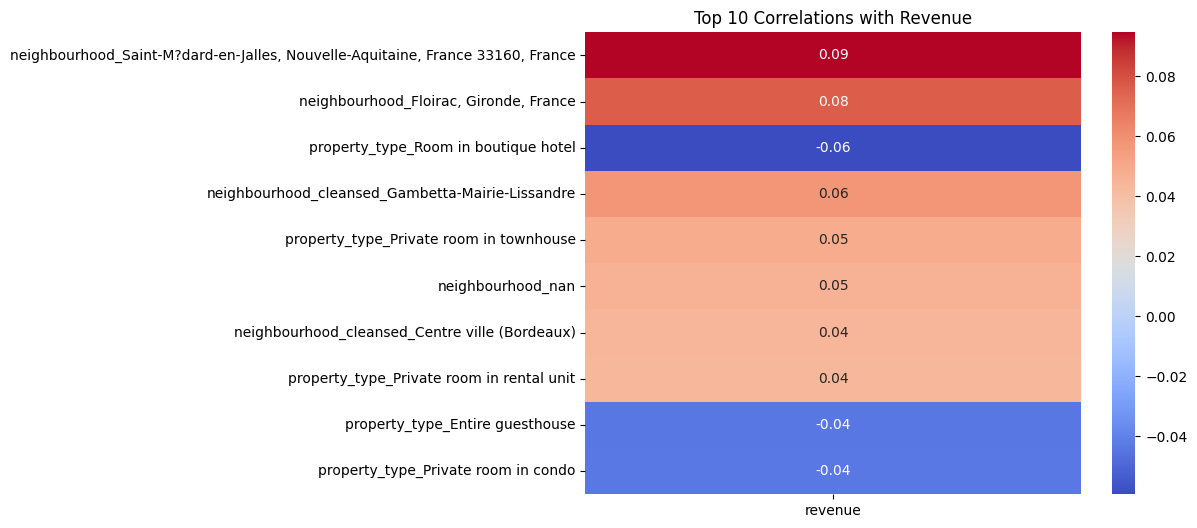

In [17]:
# Calculate the correlation of all variables with 'revenue'
correlation_with_revenue = combined_df.corr()['revenue'].sort_values(ascending=False)

# Exclude 'revenue' from itself to avoid redundancy
correlation_with_revenue = correlation_with_revenue.drop('revenue')

# Sort correlations by their absolute values to get both strong positive and negative correlations
top_10_correlations = correlation_with_revenue.abs().sort_values(ascending=False).head(10)

# Using the index of the top 10 correlations to retain the original correlation values and signs
top_10_correlations = correlation_with_revenue[top_10_correlations.index]

# Visualizing the top 10 correlations with 'revenue'
plt.figure(figsize=(8, 6))  # Adjust the figure size as needed
sns.heatmap(top_10_correlations.to_frame(), annot=True, cmap='coolwarm', cbar=True, fmt=".2f")
plt.title('Top 10 Correlations with Revenue')
plt.show()


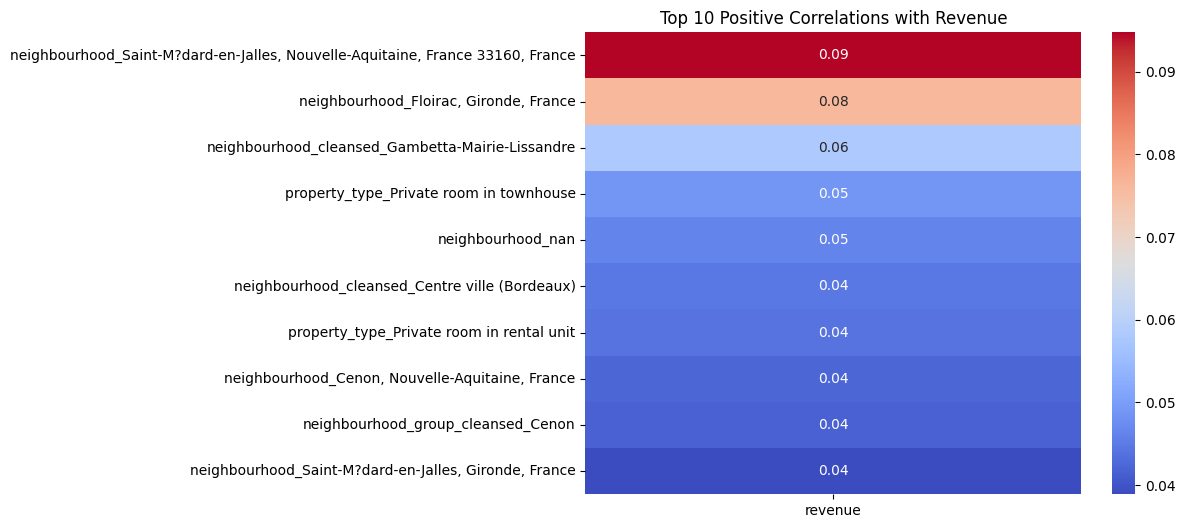

In [18]:
# Calculate the correlation of all variables with 'revenue'
correlation_with_revenue = combined_df.corr()['revenue'].sort_values(ascending=False)

# Exclude 'revenue' from itself to avoid redundancy
correlation_with_revenue = correlation_with_revenue.drop('revenue')

# Filter to keep only positive correlations
positive_correlations = correlation_with_revenue[correlation_with_revenue > 0]

# Sort the positive correlations in descending order to get the top 10
top_10_positive_correlations = positive_correlations.sort_values(ascending=False).head(10)

# Visualizing the top 10 positive correlations with 'revenue'
plt.figure(figsize=(8, 6))  # Adjust the figure size as needed
sns.heatmap(top_10_positive_correlations.to_frame(), annot=True, cmap='coolwarm', cbar=True, fmt=".2f")
plt.title('Top 10 Positive Correlations with Revenue')
plt.show()


C:\Users\user\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


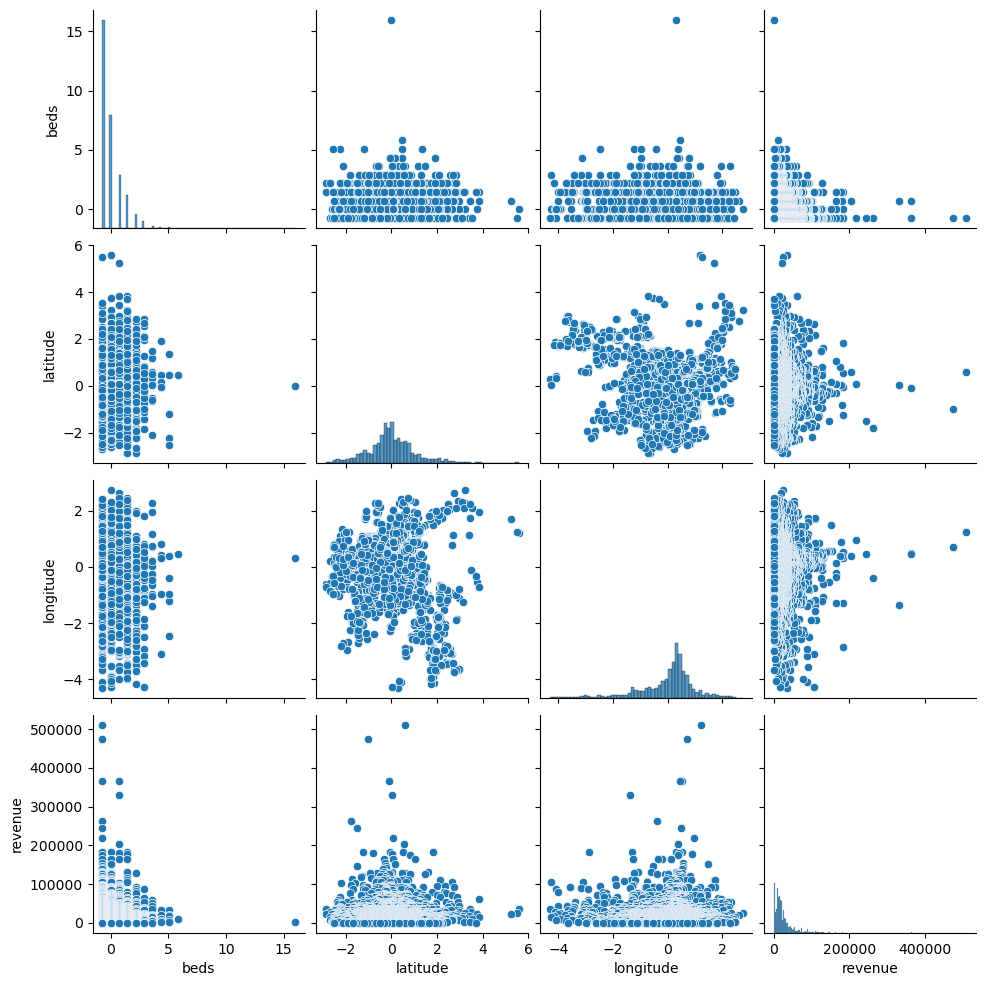

In [ ]:
import seaborn as sns

sns.pairplot(combined_df, vars=['beds', 'latitude', 'longitude', 'revenue'])


Text(0.5, 1.0, 'Top 10 Feature Importances')

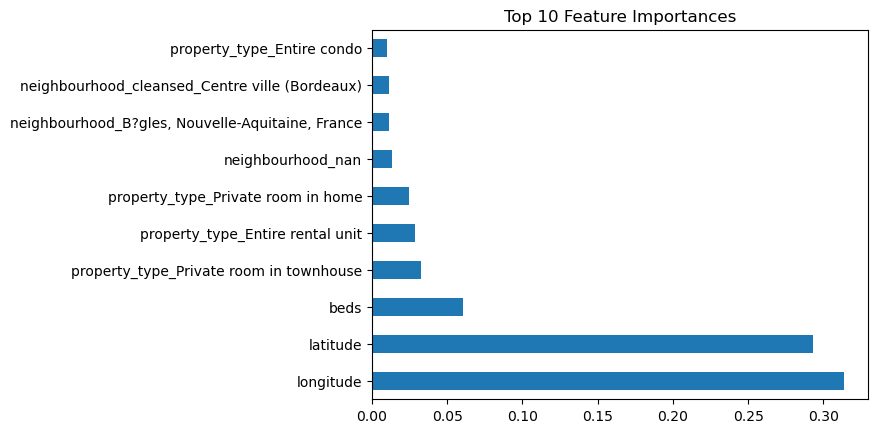

In [ ]:
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt

# Assuming 'X' is your features matrix and 'y' is the target vector (revenue)
X = combined_df.drop('revenue', axis=1)
y = combined_df['revenue']

# Fit a random forest regressor (as an example)
model = RandomForestRegressor()
model.fit(X, y)

# Visualize feature importances
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.title('Top 10 Feature Importances')


Text(0.5, 1.0, 'Revenue Distribution')

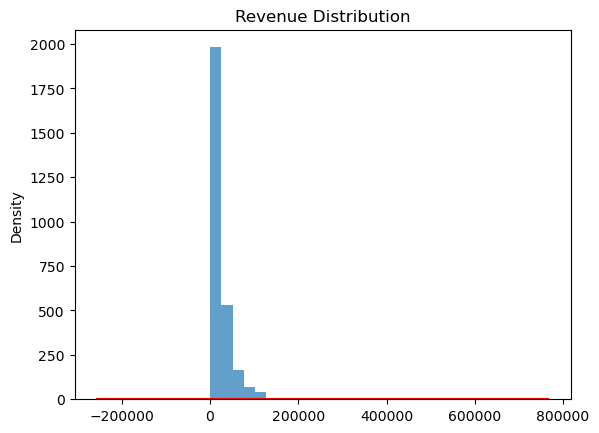

In [ ]:
# Histogram of 'revenue'
combined_df['revenue'].hist(bins=20, alpha=0.7)

# Overlay with density plot
combined_df['revenue'].plot(kind='density', color='red')
plt.title('Revenue Distribution')
